# Gesture recognition with OpenCV

The purpose of this notebook is to try and create a machine learning model that can recognize hand gestures from images. To recognize the pose of the hand I will use OpenCV with an OpenPose model. This model will return some predetermined points on the hand. Then we can train a model to classify these points into a gesture meaning. This method separates the concerns of recognizing the hand, and classifying the points.

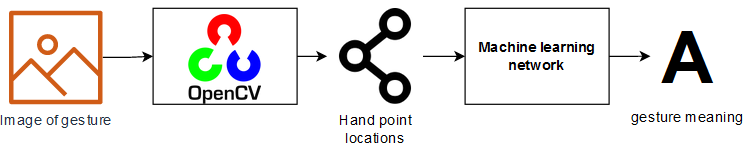

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

First, we will need to find a suitable dataset to train out model. I decided to train the model to recognize sign language numbers. *[This dataset]( https://github.com/ardamavi/Sign-Language-Digits-Dataset) has around 200 images for each number. These images are of different kinds of hand in different lighting conditions. All images are 100 by 100 pixels.
The image below is an example.

>*Mavi, A., (2020), “A New Dataset and Proposed Convolutional Neural Network Architecture for Classification of American Sign Language Digits”, arXiv:2011.08927 [cs.CV]

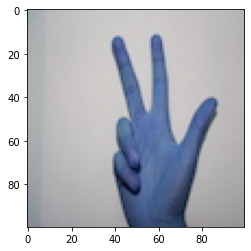

In [2]:
frame = cv2.imread("images/3/IMG_1141.JPG")
plt.imshow(frame)

## OpenCV with OpenPose

To use OpenCV we will first need to find the right model. Because we want to recognize the pose of the hand we will need to find a model which is able to do this. The OpenPose model is perfect for this. To use the model we will need to import it first. [Here](https://www.kaggle.com/changethetuneman/openpose-model?select=pose_iter_584000.caffemodel) you can find the model. We will also need to get a ‘prototxt’ file, which can be found [here]( https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/models/hand/pose_deploy.prototxt).

In [3]:
protoFile = "openpose/pose_deploy.prototxt"
weightsFile = "openpose/pose_iter_102000.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

This OpenPose model works by recognizing certain points on the hand. The input for this model is a blob, a blob represents connected regions of pixels within an image. We can pass this blob into the openPose model. And we get a list of probability maps.

In [19]:
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
aspect_ratio = frameWidth/frameHeight
threshold = 0.1

# input image dimensions for the network
inHeight = 368
# inWidth = 368
inWidth = int(((aspect_ratio*inHeight)*8)//8)
#transform image into blob
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

# get output from openpose model
output = net.forward()

The images below are examples of these probabilty maps. The region with the bright pixels is were the model predicted a certain point on the hand to be. These spots on the hand and fingers are defined by openPose model.

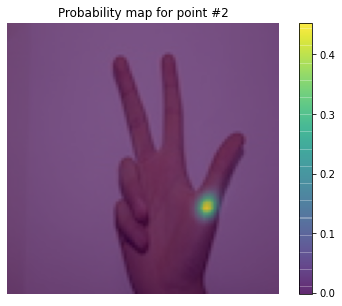

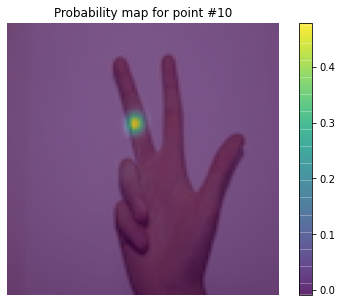

In [20]:
for i in [2, 10]:
    probMap = output[0, i, :, :]
    probMap = cv2.resize(probMap, (frame.shape[1], frame.shape[0]))
    plt.figure(figsize=[7,5])
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.imshow(probMap, alpha=0.6)
    plt.colorbar()
    plt.title('Probability map for point #{}'.format(i))
    plt.axis("off")

In model returns a total of 21 probability maps. We can now iterate through these maps to extract the points. The number of points that we can get is 21. One point on the base of the hand and 4 points for each finger. These points should always be in the same position on the hand. But if the region in the probability map is below the theshold it will not be included because it is most likely not very accurate.  In total there are 42 different values that we get, because each point has an 'x' and 'y' values. These values will be used to train out gesture recognition model. 

(59, 94)
(66, 81)
(73, 68)
(79, 53)
(85, 42)
(59, 53)
(59, 35)
(59, 22)
(59, 12)
(51, 55)
(46, 37)
(44, 24)
(42, 14)
(48, 68)
(44, 59)
(46, 61)
(44, 53)
(47, 81)
(40, 68)
(42, 74)
(50, 83)


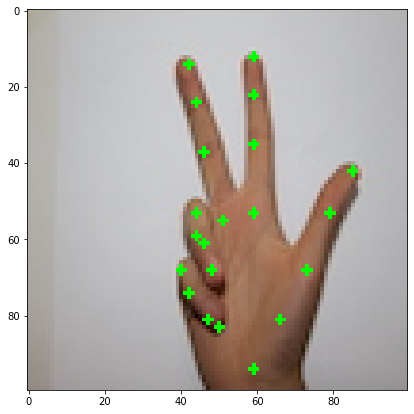

In [23]:
for i in range(21):
    # get confidence map of hand
    probMap = output[0, i, :, :]
    probMap = cv2.resize(probMap, (frameWidth, frameHeight))

    # Find maxima of the confidence map
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # draw point if probabilty is greater than theshold
    if prob > 0.1 :
        print(point)
        cv2.circle(frameCopy, (int(point[0]), int(point[1])), 1, (0, 255, 0), thickness=-1, lineType=cv2.FILLED)
    else :
        print('none')

plt.figure(figsize=[7,7])
plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))

## Processing images

Now that we know how to get the points we can make a dataset to train our model. In this dataset each row will be the points of the hand that we can recognise with OpenCV and OpenPose. When you download the [The dataset]( https://github.com/ardamavi/Sign-Language-Digits-Dataset) you folder should look something like this. Were 'notebook' is this notebook. And the 'number gestures' folder should contain the folders of each gesture. And these folders contain the corrosponding images. 

. <br>
├─ 🗋 notebook.ipynb <br>
├─ 🗁 images/ <br>
│  ├─🗀 0/ <br>
│  ├─🗀 1/ <br>
│  ├─🗀 2/ <br>
│  ├─🗀 4/ <br>
│  ├─🗀 5/ <br>
│  ├─🗀 6/ <br>
│  ├─🗀 7/ <br>
│  ├─🗀 8/ <br>
│  ├─🗀 9/ <br>
├─🗀 testImages <br>
├─...

To create the dataset we will have to get the points for each image using the OpenPose model. With the methods below we can process all images in the folders within the 'number gestures' folder. 

The method below is responsible for getting the points out of the output of the OpenPose model.

In [12]:
def get_points(nPoints, net_output, shape, threshold):
    output_points = []
    
    for i in range(nPoints):
        # get confidence map of hand
        probMap = net_output[0, i, :, :]
        probMap = cv2.resize(probMap, shape)
        
        # Find maxima of the confidence map
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
        
        # append point if probabilty is greater than theshold
        if prob > threshold:
            output_points.append(int(point[0]))
            output_points.append(int(point[1]))
        else:
            output_points.append(None)
            output_points.append(None)
            
    return output_points

The method below is responsible for transforming the image into a blob and passing this blob into the OpenPose model. Then getting the points with the 'get_points' method. And finally adding the gesture to the arary.

In [11]:
def process_image(frame):
    # input image dimensions for the network
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    inHeight = 368
    inWidth = int(((frameWidth/frameHeight*inHeight)*8)//8)
    
    #transform image into blob
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                      (0, 0, 0), swapRB=False, crop=False)
    
    # get output from openpose model
    net.setInput(inpBlob)
    output = net.forward()
    
    # get points out of output
    return get_points(21, output, (frameWidth,frameHeight), 0.1)

To process all the images in the dataset we can loop through all folders in the 'number gestures' folder. Then looping through all images in these folders. Using the 'process_image' method it processes the images one by one. Adding the ouput array to an array.

In [9]:
from IPython.display import clear_output
import os

folder = 'images'

array = []

# iterate through all folders
for subfolder in os.listdir(folder):
    sub = folder +'/'+ subfolder
    subfolder_size = len(os.listdir(sub))
    i = 0
    
    # iterate through all subfolders
    for file in os.listdir(sub):
        frame = cv2.imread(sub + '/' + file)
        points = process_image(frame)
        points_gesture = np.append(points, subfolder, axis=None)
        array.append(points_gesture)
        
        print("processing: " + subfolder)
        i += 1
        print((i/subfolder_size) * 100, '%')
        clear_output(wait=True)


processing: 9
100.0 %


After processing all images the array can be transformed into a dataframe. The first 42 columns are the points are the locations. For example, the columns '0' and '1' represent the first point and '3' and '4' represent the second point etc.. . The last column is the meaning of the gesture.

In [10]:
processed = pd.DataFrame(array)
# rename the last column to 'gesture'
processed = processed.rename(columns={processed.columns[-1]:"gesture"})
processed.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,gesture
0,66,70,55,64,44,53,39,44,35,38,...,46,62,39,53,39,48,42,48,46,0
1,52,76,57,61,59,46,62,31,59,23,...,28,42,47,44,26,51,22,55,29,0
2,55,83,51,72,46,58,None,None,None,None,...,25,57,53,59,40,59,31,60,31,0
3,51,88,46,75,None,None,None,None,None,None,...,29,45,44,50,24,57,21,64,29,0
4,31,81,None,None,None,None,70,33,73,29,...,35,40,37,55,29,63,33,68,39,0


In [ ]:
processed.to_csv('./dataframes/gesture-points-raw.csv', index=None)

In [9]:
processed = pd.read_csv('./dataframes/gesture-points-raw.csv')

## Fixing missing data

But you can also see that there are quite some 'None' values in the dataframe. So, we will have to fix these before we can start training the model.

In [11]:
processed[processed.columns[::2]].isnull().sum()

0          340
2          218
4           94
6           84
8          165
10          77
12          43
14          64
16         148
18          99
20          82
22         182
24         166
26         177
28         106
30         186
32         343
34         195
36          88
38         109
40         131
gesture      0
dtype: int64

If you look at the amount of missing cells each column has some missing values. But there is no column where all values are missing. This means we will be able to fix these missing values with the average of that column. But because we have different gestures we can only take the average of the rows with the same gesture.

So we first need to group the dataframe by gesture. Then we can iterate over all the columns in each group. And replace the missing values with the average of that column.

In [12]:
# loop through each of the gesture groups
for name, group in processed.groupby(["gesture"]):
    # loop through each column
    for label, content in group.items():
        av = content.loc[content.notna()].mean()
        form = processed['gesture'] == name 
        processed.loc[form, label] = processed.loc[form, label].fillna(int(av))

In [13]:
processed.head(5)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,gesture
0,66.0,70.0,55.0,64.0,44.0,53.0,39.0,44.0,35.0,38.0,...,46.0,62.0,39.0,53.0,39.0,48.0,42.0,48.0,46.0,0
1,52.0,76.0,57.0,61.0,59.0,46.0,62.0,31.0,59.0,23.0,...,28.0,42.0,47.0,44.0,26.0,51.0,22.0,55.0,29.0,0
2,55.0,83.0,51.0,72.0,46.0,58.0,62.0,43.0,66.0,35.0,...,25.0,57.0,53.0,59.0,40.0,59.0,31.0,60.0,31.0,0
3,51.0,88.0,46.0,75.0,55.0,54.0,62.0,43.0,66.0,35.0,...,29.0,45.0,44.0,50.0,24.0,57.0,21.0,64.0,29.0,0
4,31.0,81.0,47.0,66.0,55.0,54.0,70.0,33.0,73.0,29.0,...,35.0,40.0,37.0,55.0,29.0,63.0,33.0,68.0,39.0,0


In [14]:
print('There are {} missing values'.format(processed.isnull().sum().sum()))

There are 0 missing values


## Pre-processing dataframe

To do this we first need to split the dataset into the gesture meaning and the actual points.

In [15]:
gesture_points = processed.drop(['gesture'], axis=1)
gesture_meaning = processed['gesture']

In [ ]:
blank = np.zeros((100,100,3), np.uint8)

## Normalizing dataframe

Before we start training the model we still need to do some work on the dataframe. The points in each of the rows are relative to the image, which won't be good when modeling. Because the actual hand might be in a different location depending on the image, even through the same gesture is begin made. So, we will need to get the position data out of the hand while getting rid of the difference in location within the image. Another problem is the difference of size of the hand in the image. Because when the hand is closer or futher away from the camera the points will be different, but the gesture will be the same.
Normalizing the dataframe solves both of these problems. Each of the values in the dataframe will be mapped between 1 and 0. So you could say that the location of the hand changes because the points are moved between 1 and 0. Also the scale will be changed because again they are between 1 and 0. This means that now the scale and location of the hands are all bewteen 1 and 0.

($inputvalue – $min) / ($max – $min)

In [16]:
for index, row in gesture_points.iterrows():
    reshape = np.asarray([row[i::2] for i in range(2)])
    min = reshape.min(axis=1, keepdims=True)
    max = reshape.max(axis=1, keepdims=True)
    normalized = np.stack((reshape-min)/(max-min), axis=1).flatten()
    gesture_points.iloc[[index]] = [normalized]

In [17]:
gesture_points.head(3)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,1.000000,1.0,0.645161,0.877551,0.290323,0.653061,0.129032,0.469388,0.000000,0.346939,...,0.354839,0.510204,0.870968,0.367347,0.580645,0.367347,0.419355,0.428571,0.419355,0.510204
1,0.565217,1.0,0.782609,0.741379,0.869565,0.482759,1.000000,0.224138,0.869565,0.086207,...,0.782609,0.172414,0.130435,0.500000,0.217391,0.137931,0.521739,0.068966,0.695652,0.189655
2,0.607143,1.0,0.464286,0.819672,0.285714,0.590164,0.857143,0.344262,1.000000,0.213115,...,0.750000,0.049180,0.678571,0.508197,0.750000,0.295082,0.750000,0.147541,0.785714,0.147541


Text(0.5, 1.0, 'normalized gesture')

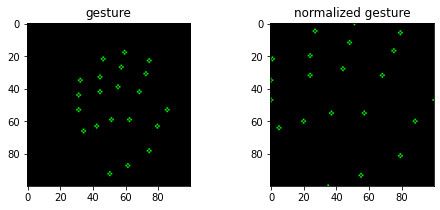

In [18]:
index = 1100
copy, copy_norm = np.copy(blank), np.copy(blank)
for n, m in zip(np.reshape(processed.drop(['gesture'], axis=1).iloc[[index]].values, (-1, 2)), 
                np.reshape(gesture_points.iloc[[index]].values, (-1, 2))):
    cv2.circle(copy, (int(n[0]), int(n[1])), 1, (0, 255, 0))
    cv2.circle(copy_norm, (int(m[0]*100), int(m[1]*100)), 1, (0, 255, 0))

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(copy)
axes[0].set_title('gesture')
axes[1].imshow(copy_norm)
axes[1].set_title('normalized gesture')

## Flipping

And as you can see all points in the dataset have been normalized between 1 and 0. fixing both the location and scale issue while preserving the position of the hand/fingers. After that we can put the meaning of the gesture back at the end of the dataframe to complete it. 

In [19]:
flipped_gesture_points = gesture_points.copy()
for c in flipped_gesture_points.columns.values[::2]:
    flipped_gesture_points.loc[:, c] = (1 - flipped_gesture_points.loc[:, c])
flipped_gesture_points.head(3)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.000000,1.0,0.354839,0.877551,0.709677,0.653061,0.870968,0.469388,1.000000,0.346939,...,0.645161,0.510204,0.129032,0.367347,0.419355,0.367347,0.580645,0.428571,0.580645,0.510204
1,0.434783,1.0,0.217391,0.741379,0.130435,0.482759,0.000000,0.224138,0.130435,0.086207,...,0.217391,0.172414,0.869565,0.500000,0.782609,0.137931,0.478261,0.068966,0.304348,0.189655
2,0.392857,1.0,0.535714,0.819672,0.714286,0.590164,0.142857,0.344262,0.000000,0.213115,...,0.250000,0.049180,0.321429,0.508197,0.250000,0.295082,0.250000,0.147541,0.214286,0.147541


Text(0.5, 1.0, 'flipped gesture')

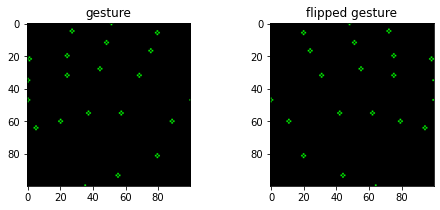

In [20]:
copy, copy_flipped = np.copy(blank), np.copy(blank)
for n, f in zip(np.reshape(gesture_points.iloc[[index]].values, (-1, 2)),  
                    np.reshape(flipped_gesture_points.iloc[[index]].values, (-1, 2))):
    cv2.circle(copy, (int(n[0]*100), int(n[1]*100)), 1, (0, 255, 0))
    cv2.circle(copy_flipped, (int(f[0]*100), int(f[1]*100)), 1, (0, 255, 0))
    
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(copy)
axes[0].set_title('gesture')
axes[1].imshow(copy_flipped)
axes[1].set_title('flipped gesture')

## Finalizing dataframe

In [28]:
gestures = pd.concat([gesture_points, gesture_meaning], axis=1)
reverse_gestures = pd.concat([flipped_gesture_points, gesture_meaning], axis=1)
gesture_dataframe = gestures.append(reverse_gestures, ignore_index=True)

In [33]:
gesture_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4124 entries, 0 to 4123
Data columns (total 43 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   0        4124 non-null   float64
 1   1        4124 non-null   float64
 2   2        4124 non-null   float64
 3   3        4124 non-null   float64
 4   4        4124 non-null   float64
 5   5        4124 non-null   float64
 6   6        4124 non-null   float64
 7   7        4124 non-null   float64
 8   8        4124 non-null   float64
 9   9        4124 non-null   float64
 10  10       4124 non-null   float64
 11  11       4124 non-null   float64
 12  12       4124 non-null   float64
 13  13       4124 non-null   float64
 14  14       4124 non-null   float64
 15  15       4124 non-null   float64
 16  16       4124 non-null   float64
 17  17       4124 non-null   float64
 18  18       4124 non-null   float64
 19  19       4124 non-null   float64
 20  20       4124 non-null   float64
 21  21       4124 

Now that the dataframe has been processed we can save it as a CSV file so that later we can just import the dataset instead of running everything again.

In [34]:
gesture_dataframe.to_csv('./dataframes/gesture-points-processed.csv', index=None)

In [3]:
gesture_dataframe = pd.read_csv('./dataframes/gesture-points-processed.csv')

## Modeling

Now we can start training a model. To train the model we will first need to split the dataset into a test and train set. As the names imply the train set is used to train the model and the test set to test and validate the model. Each of the train and test sets have an X and Y set. The 'X' is the points data and the 'y' is the label, which in this case is the meaning of the gesture.

In [4]:
gesture_dataframe = gesture_dataframe.astype(float)
gesture_dataframe.gesture = gesture_dataframe.gesture.astype(str)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(gesture_dataframe.drop('gesture', axis=1), 
                                                    gesture_dataframe['gesture'],
                                                    test_size = 0.2, 
                                                    random_state=42)

To choose the right algorithm we will use this chart from Sklearn. Different algorithms are better suited for different types of data and different problems. So, we will be following this chart. First we have to check if the dataset has more than 50 samples, which we do because we have over 2000 rows. Than it asks if we are predicting a catagory/label, we are trying to predict the label/meaning of a gesture so this will be a 'yes'. Than we have to check if our data is labeled. It is, because the last column has the meaning of the gesture. Than we need to check if the dataset has less than 100000 samples. We do have less data than that. So, we end up with the 'LinearSVC' estimator. 

![estimator chart](https://scikit-learn.org/stable/_static/ml_map.png)

Now we can train the model. From the chart above we have concluded that the linearSVC would be best fitted for this dataset. So, we can train the model with the training set. And then we can score the model with the test dataset.

In [8]:
from sklearn.svm import SVC
import time

start = time.time()
#Training model
svm_model = SVC(kernel='poly', random_state=42, C=1.0, probability=True)
svm_model.fit(X_train, y_train)

#Calculating elapsed time
stop = time.time()
elapsed_time = ((stop - start) / 60)
print('Training time: {} minutes and {} seconds'
.format(int(elapsed_time), int(((elapsed_time % 1) * 60))))
    
#Calculating score
print('Score:',svm_model.score(X_test, y_test).round(2))

Training time: 0 minutes and 1 seconds
Score: 0.95


### Validating the model

To visualize how the model preforms we can create a confusion matrix. Each row of the matrix represents the a predicted value, while each column is the instances in an actual value.
All labels have a score higher than 0.9. There is also a gestures were the model scores a 1. This could mean that this gesture is overfitted to the data. But i assume it is not, because the dataset has a lot of varity in the images. From this matrix we can assume that the model is able to clearly seperate each gesture.

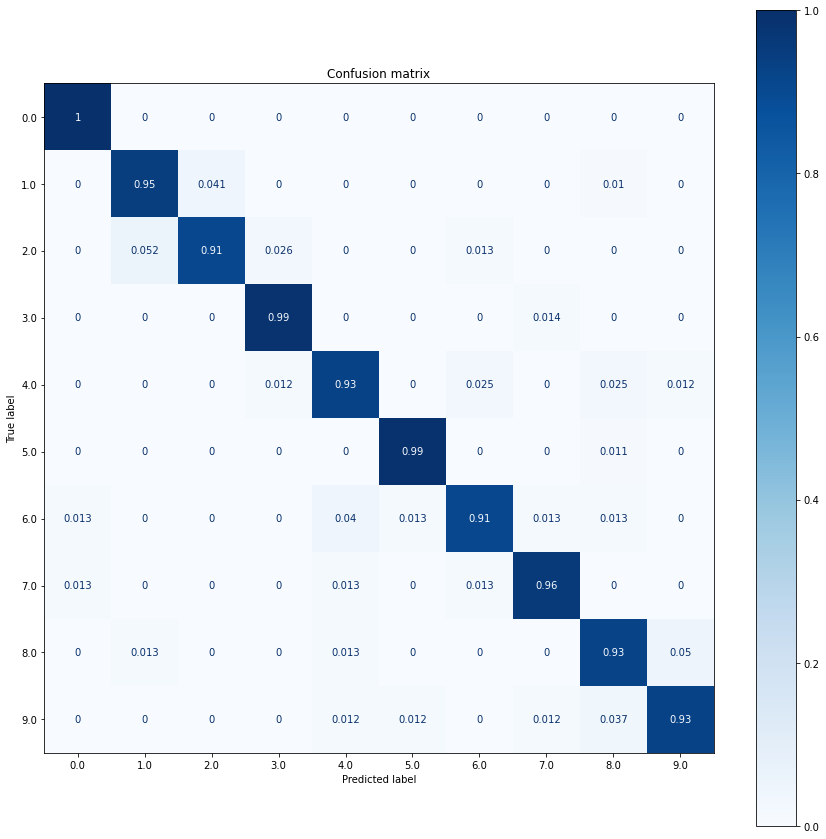

In [6]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(15, 15))
matrix = plot_confusion_matrix(svm_model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 ax=ax)
plt.title('Confusion matrix')
plt.show(matrix)
plt.show()

### Testing the model

Finally we can test the model with images it has not seen before. For this test we will use Mediapipe instead of OpenCV. This is because the Mediapipe hands model is much faster than using the handpose model. Another reason to use this model is that it's able to recognize multiple hands in one image. The images used for testing are in the [`test_images`](test_images) folder. This folder contains 20 images, two for each gesture. Each gesture has a right and left hand image to test if the model can predict both hands. For each image a graph is created with the confidence for each gesture label. The higher the bar the more confident the model is that it's the right label. Of course, the label with the highest confidence will be seen as the predicted label.

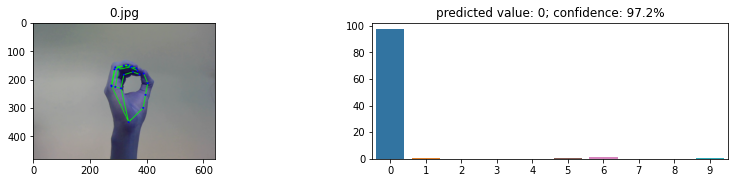

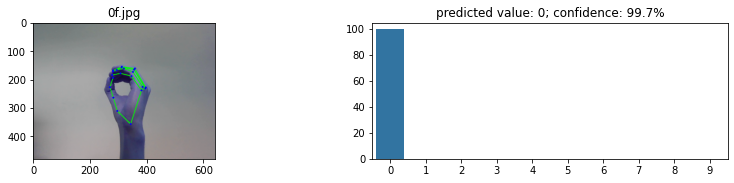

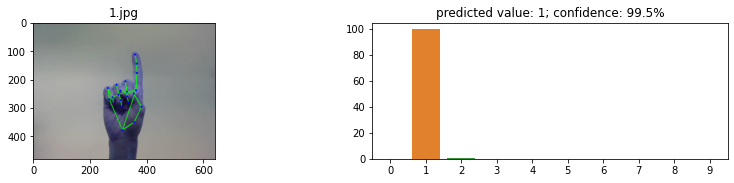

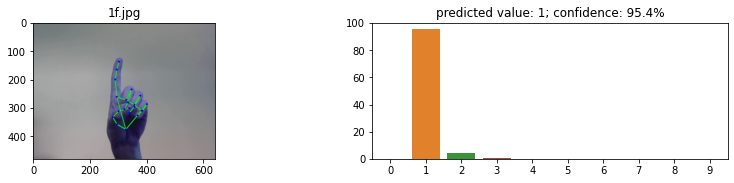

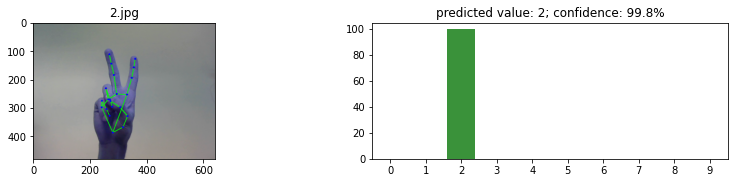

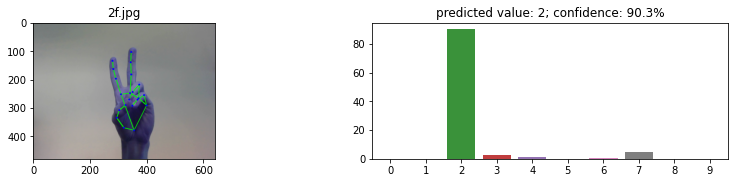

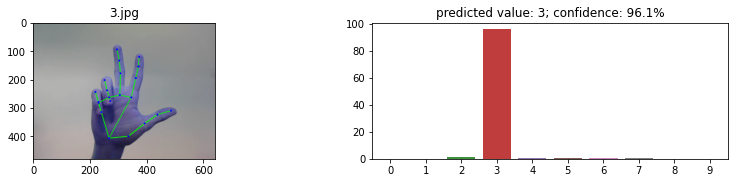

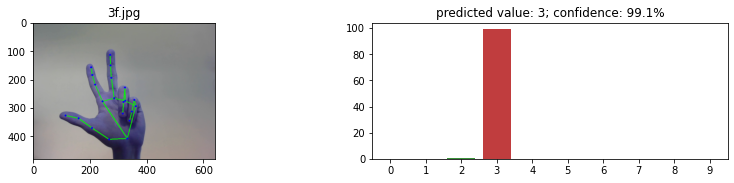

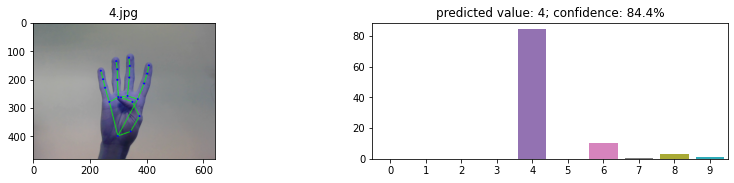

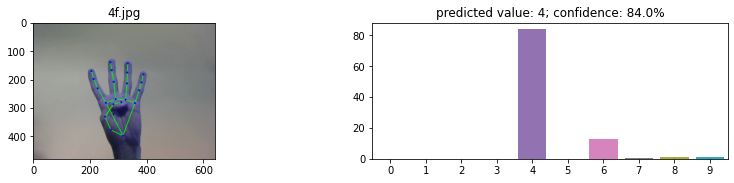

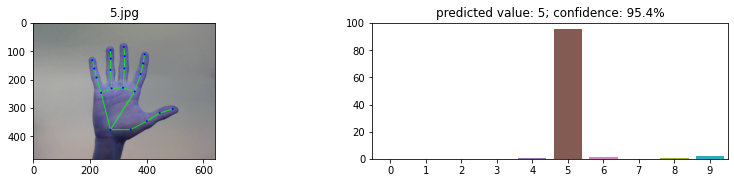

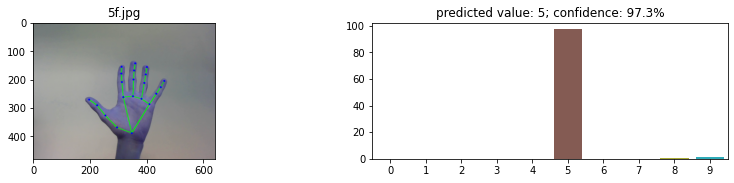

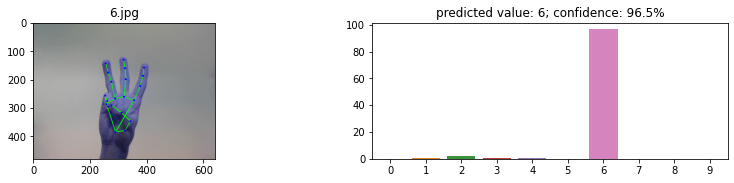

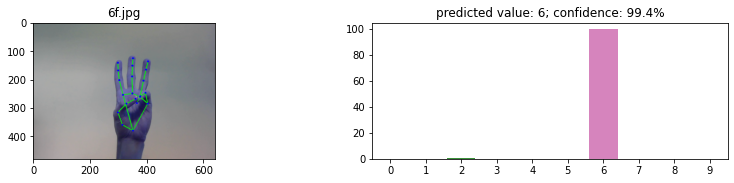

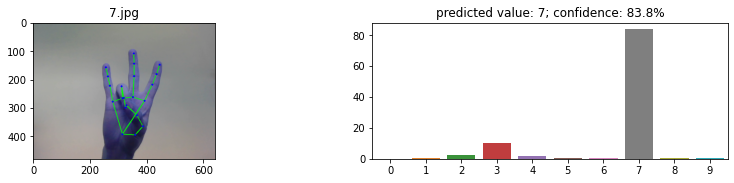

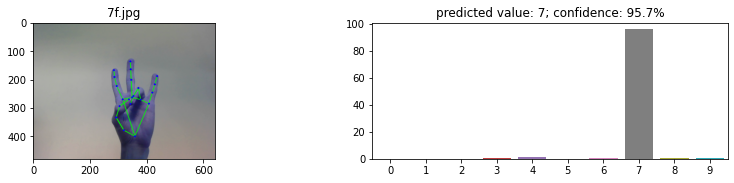

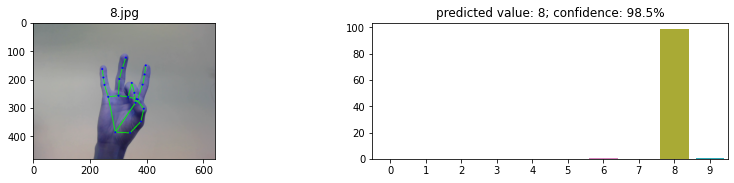

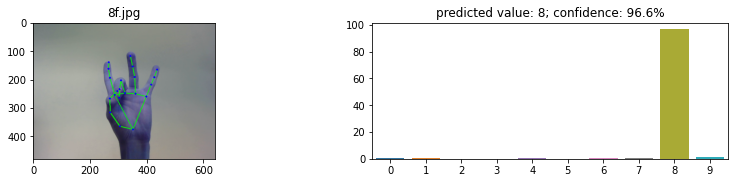

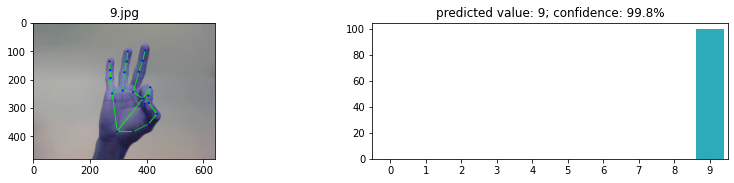

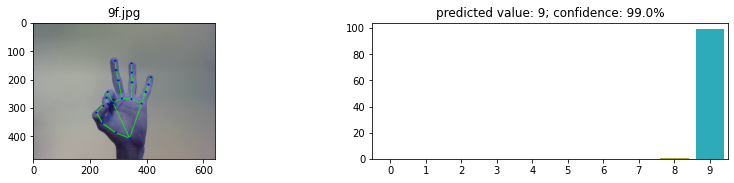

In [7]:
from mediapipe.python.solutions import drawing_utils, hands
import os

# load the mediapipe hand model
hand_model = hands.Hands(static_image_mode=True)

# loop through each image in the test folder
for file in os.listdir('test_images'):
    example_im = cv2.imread('test_images/' + file)
    # get prediction of hand model
    results = hand_model.process(cv2.cvtColor(example_im, cv2.COLOR_BGR2RGB))
    # draw skeleton on image
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0]
        drawing_utils.draw_landmarks(example_im, landmarks, hands.HAND_CONNECTIONS)
        
        # get x and y values out of prediction
        x, y = [], []
        for lm in landmarks.landmark:
            x.append(lm.x)
            y.append(lm.y)
                
        #normalize points
        points = np.asarray([x,y])
        min = points.min(axis=1, keepdims=True)
        max = points.max(axis=1, keepdims=True)
        normalized = np.stack((points-min)/(max-min), axis=1).flatten()
        # get prediction from gesture model
        pred = svm_model.predict_proba([normalized])
        
        # get gesture prediction and confidence
        gesture = pred.argmax(axis=1)[0]
        confidence = pred.max()
        
        # Show image and draw graph
        fig, axes = plt.subplots(1, 2, figsize=(14, 2.5))
        axes[0].imshow(example_im, cmap=plt.cm.gray)
        axes[0].set_title(file)
        sns.barplot(y=(pred[0] * 100), x=np.arange(10))
        axes[1].set_title('predicted value: {}; confidence: {:.1%}'.format(gesture, confidence))

The results of this test are pretty successfull. All test images were predicted correctly and the confidence never dipped below 80%. The gesture with the lowest confidence is '4', with both the left and right hand having a confidence of around 84%

In [11]:
import joblib

joblib.dump(svm_model, './model/gesture_model.pkl', compress=9)

['./model/gesture_model.pkl']